In [ ]:
#Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import data
metadata = pd.read_csv('/content/drive/MyDrive/CSCI_567/Project/application_metadata.csv')

In [ ]:
metadata['status'].value_counts()

ISS     3139764
ABN      977521
PEND     798795
Name: status, dtype: int64

In [ ]:
#Removing pending patents
metadata = metadata[metadata['status'] != 'PEND']

In [ ]:
metadata['status'].value_counts()

ISS    3139764
ABN     977521
Name: status, dtype: int64

In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4117285 entries, 0 to 4915887
Data columns (total 8 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   doc-id                    int64  
 1   examiner_experience       int64  
 2   examiner_allowance_ratio  float64
 3   class_saturation          int64  
 4   subclass_saturation       int64  
 5   customer_experience       int64  
 6   customer_success_ratio    float64
 7   status                    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 282.7+ MB


In [ ]:
metadata.describe()

,doc-id,examiner_experience,examiner_allowance_ratio,class_saturation,subclass_saturation,customer_experience,customer_success_ratio
count,4.117285e+06,4.117285e+06,4.117285e+06,4.117285e+06,4.117285e+06,4.117285e+06,4.117285e+06
mean,1.234501e+07,5.029763e+02,7.643155e-01,1.675307e+04,2.954730e+03,5.029763e+02,7.643155e-01
std,5.607356e+06,1.320641e+03,2.228962e-01,2.099201e+04,3.829545e+03,1.320641e+03,2.228962e-01
min,2.618355e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.010214e+07,1.030000e+02,6.315789e-01,2.936000e+03,4.590000e+02,1.030000e+02,6.315789e-01
50%,1.140475e+07,2.630000e+02,8.390142e-01,8.520000e+03,1.750000e+03,2.630000e+02,8.390142e-01
75%,1.262732e+07,5.720000e+02,9.437908e-01,2.127600e+04,4.032000e+03,5.720000e+02,9.437908e-01
max,9.603000e+07,2.694000e+04,1.000000e+00,1.255260e+05,3.846600e+04,2.694000e+04,1.000000e+00


In [ ]:
#Data seems to be skewed by earlier results. Taking only last ~1,000,000
metadata = metadata[3000000:]

In [ ]:
#Encoding target feature
metadata['status'] = metadata['status'].replace({'ISS': 1, 'ABN': 0})
metadata['status'].value_counts()

1    844069
0    273216
Name: status, dtype: int64

In [ ]:
#Splitting into train and test (not shuffling to keep data sequential)
from sklearn.model_selection import train_test_split

X = metadata.drop(['status', 'doc-id'], axis=1)
y = metadata['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

In [ ]:
#Scaling data using Standard Scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_standard = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_standard = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

Model Training and Evaluation

In [ ]:
matrix = metadata.corr()
matrix

,doc-id,examiner_experience,examiner_allowance_ratio,class_saturation,subclass_saturation,customer_experience,customer_success_ratio,status
doc-id,1.000000,0.474872,0.349853,-0.144756,0.035760,0.474872,0.349853,0.161558
examiner_experience,0.474872,1.000000,0.586142,-0.183698,-0.001417,1.000000,0.586142,0.219323
examiner_allowance_ratio,0.349853,0.586142,1.000000,-0.208649,-0.010090,0.586142,1.000000,0.396061
class_saturation,-0.144756,-0.183698,-0.208649,1.000000,0.010272,-0.183698,-0.208649,-0.056347
subclass_saturation,0.035760,-0.001417,-0.010090,0.010272,1.000000,-0.001417,-0.010090,-0.006817
customer_experience,0.474872,1.000000,0.586142,-0.183698,-0.001417,1.000000,0.586142,0.219323
customer_success_ratio,0.349853,0.586142,1.000000,-0.208649,-0.010090,0.586142,1.000000,0.396061
status,0.161558,0.219323,0.396061,-0.056347,-0.006817,0.219323,0.396061,1.000000


In [ ]:
plt.figure(figsize=(36,36), dpi = 480)
sns.heatmap(matrix, annot=True)
plt.show()

# Prev

In [ ]:
#Training and evluating XGBoost
from xgboost import XGBClassifier

xgb = XGBClassifier()#tree_method='gpu_hist')
xgb.fit(X_train_standard, y_train)

y_pred = xgb.predict(X_test_standard)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')

Accuracy: 0.8331
Precision: 0.8724
Recall: 0.9368
F1: 0.9034


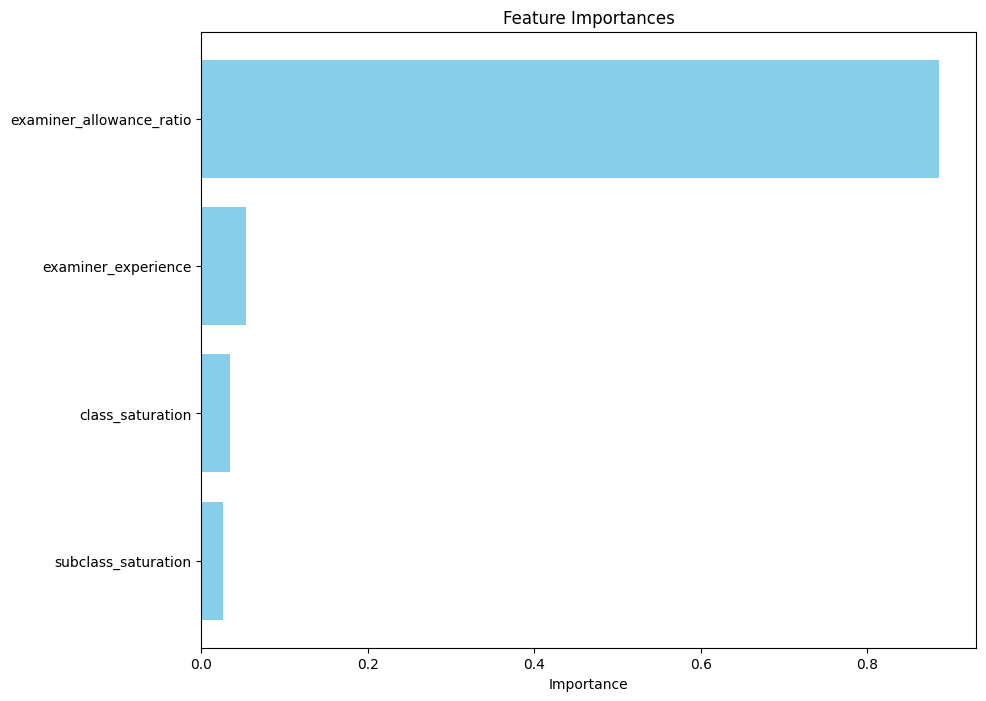

In [ ]:
importances = xgb.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the features by importance
feature_importances_sorted = feature_importances.sort_values(by='Importance', ascending=True)

# Creating the bar plot
plt.figure(figsize=(10, 8))
plt.barh(feature_importances_sorted['Feature'][2:], feature_importances_sorted['Importance'][2:], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

In [ ]:
#Training and evaluating Logistic Regression classifier
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')

Accuracy: 0.8336
Precision: 0.8336
Recall: 1.0000
F1: 0.9093


In [ ]:
#Training and evaluating Logistic Regression classifier
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train_standard, y_train)

y_pred = log_reg.predict(X_test_standard)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')

Accuracy: 0.8329
Precision: 0.8750
Recall: 0.9327
F1: 0.9029


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

Confusion Matrix:  
[[ 12371  24809]
 [ 12539 173738]]


AUC:   0.632709460131391

ROC:  


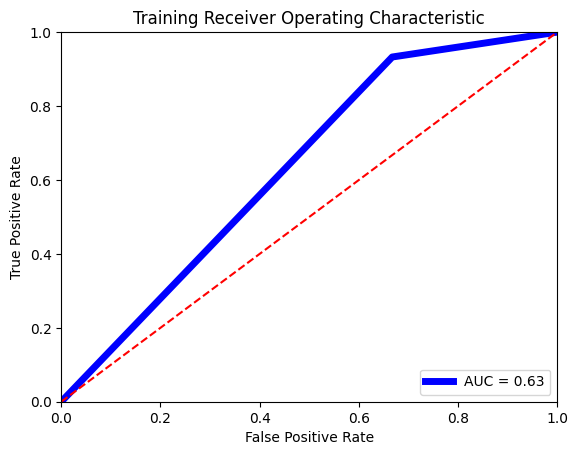

In [ ]:
print("Confusion Matrix:  ")
print(confusion_matrix(y_test, y_pred))

fpr, tpr, threshold = roc_curve(y_test, y_pred)

roc_auc = auc(fpr, tpr)
print( end="\n\n")
print("AUC:  ",roc_auc, end="\n\n")

print("ROC:  ")
plt.title('Training Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc, linewidth=5)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Log Reg + RFE

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import math
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import statsmodels.api as sm
from sklearn.feature_selection import RFECV
from itertools import compress
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

In [ ]:
kf = StratifiedKFold(n_splits=5 , random_state=123, shuffle=True)

In [ ]:
y_train = list(y_train)

In [ ]:
log_r_model = LogisticRegression(random_state=0, penalty=None)
selector = RFECV(log_r_model, step=1, cv=StratifiedKFold(5))

selector = selector.fit(X_train, y_train)

# number of features chosen for cross validation
p = selector.n_features_

# get the selected features from rfecv
X_train_rfe = selector.fit_transform(X_train, y_train)

curr_features = list(compress( list(X_train.columns), selector.get_support()))

log_r_model = log_r_model.fit(X_train_rfe, y_train)

# predictions
y_pred = selector.predict(X_train)

# Max of list of mean of scores over the folds
curr_score = max(selector.cv_results_["mean_test_score"])

X_train_rfe = sm.add_constant(X_train_rfe)

logit_mod = sm.Logit(y_train, X_train_rfe)
log_reg = logit_mod.fit(method="bfgs", maxiter=22)

print(log_reg.summary())
print()


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: 0.545232
         Iterations: 10
         Function evaluations: 21
         Gradient evaluations: 15
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               893828
Model:                          Logit   Df Residuals:                   893826
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Dec 2023   Pseudo R-squ.:                 0.05551
Time:                        01:21:10   Log-Likelihood:            -4.8734e+05
converged:                       True   LL-Null:                   -5.1598e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3354      0.004     8

Best score Validation:   0.740817014257868

Training parameters:
Number of features:   1

P-values:         [0. 0.]

Coefficients:     [0.33537316 0.00132161]

Confusion Matrix:  
[[     0 236036]
 [     0 657792]]


AUC:   0.5

ROC:  


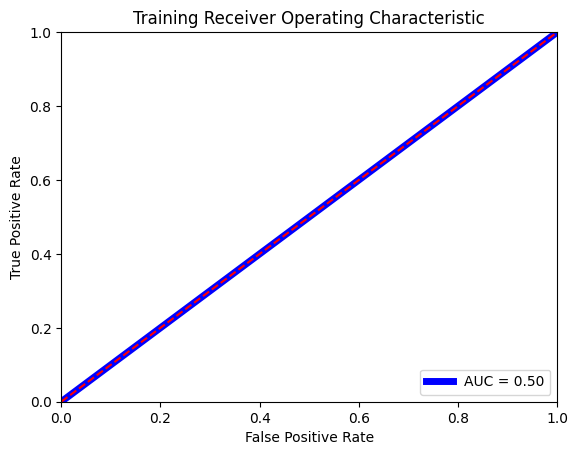

In [ ]:
print("Best score Validation:  ", curr_score, end="\n\n")

print("Training parameters:")
print("Number of features:  ", p, end="\n\n")

print("P-values:        ", log_reg.pvalues, end="\n\n")
print("Coefficients:    ", log_reg.params, end="\n\n")

print("Confusion Matrix:  ")
print(confusion_matrix(y_train, y_pred))

fpr, tpr, threshold = roc_curve(y_train, y_pred)

roc_auc = auc(fpr, tpr)
print( end="\n\n")
print("AUC:  ",roc_auc, end="\n\n")

print("ROC:  ")
plt.title('Training Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc, linewidth=5)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### no learning with RFE + Log Reg
### It looks like RFE eliminates too many features

### Let's try SMOTE to see if anything changes with this pipeline

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

In [ ]:
smote = SMOTE(random_state=0)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

In [ ]:
y_train_SMOTE = np.array(y_train_SMOTE)

In [ ]:
# Counting 1s
count_ones = np.count_nonzero(y_train_SMOTE)

# Counting 0s
count_zeros = y_train_SMOTE.size - count_ones

print(f"Number of 0s: {count_zeros}")
print(f"Number of 1s: {count_ones}")

Number of 0s: 657792
Number of 1s: 657792


In [ ]:
#Training and evaluating Logistic Regression classifier
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train_SMOTE, y_train_SMOTE)

y_pred = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')

Accuracy: 0.6391
Precision: 0.8805
Recall: 0.6561
F1: 0.7519


In [ ]:
log_r_model = LogisticRegression(random_state=0, penalty=None)
selector = RFECV(log_r_model, step=1, cv=StratifiedKFold(5))

selector = selector.fit(X_train_SMOTE, y_train_SMOTE)

# number of features chosen for cross validation
p = selector.n_features_

# get the selected features from rfecv
X_train_rfe = selector.fit_transform(X_train_SMOTE, y_train_SMOTE)

curr_features = list(compress( list(X_train_SMOTE.columns), selector.get_support()))

log_r_model = log_r_model.fit(X_train_rfe, y_train_SMOTE)

# predictions
y_pred = selector.predict(X_train_SMOTE)

# Max of list of mean of scores over the folds
curr_score = max(selector.cv_results_["mean_test_score"])

X_train_rfe = sm.add_constant(X_train_rfe)

logit_mod = sm.Logit(y_train_SMOTE, X_train_rfe)
log_reg = logit_mod.fit(method="bfgs", maxiter=22)

print(log_reg.summary())
print()

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: 0.649367
         Iterations: 11
         Function evaluations: 20
         Gradient evaluations: 14
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:              1315584
Model:                          Logit   Df Residuals:                  1315582
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Dec 2023   Pseudo R-squ.:                 0.06316
Time:                        01:24:15   Log-Likelihood:            -8.5430e+05
converged:                       True   LL-Null:                   -9.1189e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6865      0.003   -24

Best score Validation:   0.6179309109651527

Training parameters:
Number of features:   1

P-values:         [0. 0.]

Coefficients:     [-0.6865267   0.00131839]

Confusion Matrix:  
[[481050 176742]
 [325775 332017]]


AUC:   0.6180274311636506

ROC:  


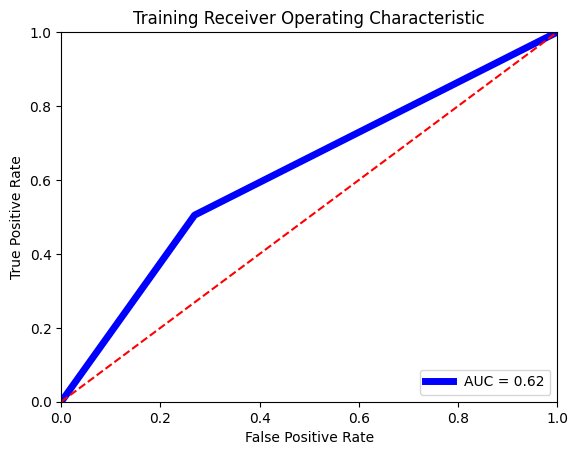

In [ ]:
print("Best score Validation:  ", curr_score, end="\n\n")

print("Training parameters:")
print("Number of features:  ", p, end="\n\n")

print("P-values:        ", log_reg.pvalues, end="\n\n")
print("Coefficients:    ", log_reg.params, end="\n\n")

print("Confusion Matrix:  ")
print(confusion_matrix(y_train_SMOTE, y_pred))

fpr, tpr, threshold = roc_curve(y_train_SMOTE, y_pred)

roc_auc = auc(fpr, tpr)
print( end="\n\n")
print("AUC:  ",roc_auc, end="\n\n")

print("ROC:  ")
plt.title('Training Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc, linewidth=5)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Accuracy: 0.6196
Precision: 0.8951
Recall: 0.6158
F1: 0.7297
[[ 23729  71559]
 [ 13451 114718]]


AUC:   0.5720383186239879

ROC:  


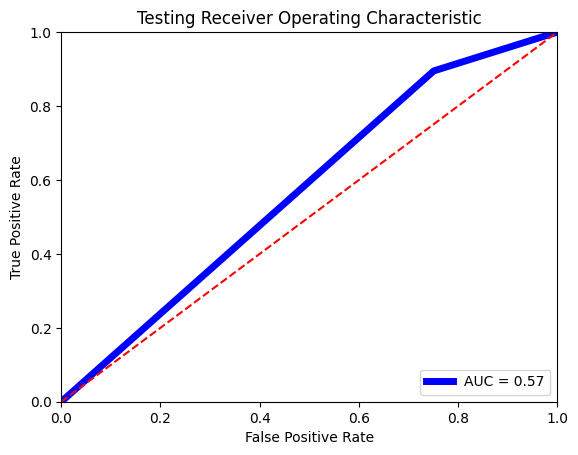

In [ ]:
X_test_rfe = X_test[list(curr_features)].to_numpy()

y_pred = log_r_model.predict(X_test_rfe)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')

print(confusion_matrix(y_pred, y_test))


fpr, tpr, threshold = roc_curve(y_pred, y_test)

roc_auc = auc(fpr, tpr)
print( end="\n\n")
print("AUC:  ",roc_auc, end="\n\n")

print("ROC:  ")
plt.title('Testing Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc, linewidth=5)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### L-1 penalized log reg

In [ ]:
X_train

,examiner_experience,examiner_allowance_ratio,class_saturation,subclass_saturation,customer_experience,customer_success_ratio
3046228,144,0.736111,6510,4124,144,0.736111
3046230,784,0.760204,66292,207,784,0.760204
3046231,263,0.574144,7344,8754,263,0.574144
3046232,212,0.561321,53539,2472,212,0.561321
3046233,164,0.707317,4946,25336,164,0.707317
...,...,...,...,...,...,...
4129789,443,0.406321,2892,1079,443,0.406321
4129790,695,0.887770,7433,5959,695,0.887770
4129791,1689,0.846655,28438,1921,1689,0.846655
4129792,477,0.742138,10337,35548,477,0.742138


In [ ]:
X_train_l1 = X_train.copy()
X_test_l1 = X_test.copy()

In [ ]:
scaler = MinMaxScaler()
# Normalization recommended

for col_name in X_train_l1.columns:
    X_train_l1[col_name] = scaler.fit_transform(np.array(X_train_l1[col_name]).reshape(-1, 1))
    X_test_l1[col_name] = scaler.fit_transform(np.array(X_test_l1[col_name]).reshape(-1, 1))

X_train_l1 = X_train_l1.to_numpy()
X_test_l1 = X_test_l1.to_numpy()

lasso_reg = LassoCV(cv=StratifiedKFold(5),
                    random_state=0, tol = 0.01).fit(X_train_l1, y_train)

lambda_weight = lasso_reg.alpha_

log_r_model = LogisticRegressionCV(cv=5, Cs = [1/lambda_weight], random_state=0, solver='liblinear', penalty="l1")

log_r_model = log_r_model.fit(X_train_l1, y_train)
score_dict = log_r_model.scores_
key = list(score_dict.keys())[0]
validation_score = score_dict[key].mean(axis=0).max()

# predictions
test_score = log_r_model.score(X_test_l1, y_test)
y_pred_test = log_r_model.predict(X_test_l1)

# best budget/L_1 penalty
c = log_r_model.C_

In [ ]:
print("Accuracy:  ", test_score, end="\n\n")
print("Validation score:  ", validation_score, end="\n\n")
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')

Accuracy:   0.8326255163185758

Validation score:   0.7633124123335182

Accuracy: 0.8326
Precision: 0.8755
Recall: 0.9318
F1: 0.9027




AUC:   0.6338158130997559

ROC:  


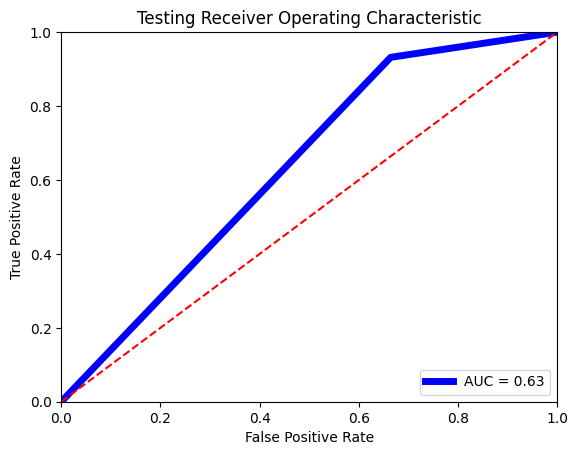

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_test)

roc_auc = auc(fpr, tpr)
print( end="\n\n")
print("AUC:  ",roc_auc, end="\n\n")

print("ROC:  ")
plt.title('Testing Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc, linewidth=5)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Well that did nothing